In [1]:
# Initial Imports
import numpy as np
import pandas as pd

In [2]:
# Set the random see for reproducibility
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [3]:
# # Load the fear and greed sentiment data for Bitcoin
df = pd.read_csv('btc_sentiment.csv', index_col="date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns="fng_classification")
df.head()

,fng_value
date,
2019-07-29,19
2019-07-28,16
2019-07-27,47
2019-07-26,24
2019-07-25,42


In [4]:
# Load the historical closing prices for Bitcoin
df2 = pd.read_csv('btc_historic.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)['Close']
df2 = df2.sort_index()
df2.tail()

Date
2019-07-25    9882.429688
2019-07-26    9847.450195
2019-07-27    9478.320313
2019-07-28    9531.769531
2019-07-29    9529.889648
Name: Close, dtype: float64

In [5]:
# Join the data into a single dataframe
df = df.join(df2, how="inner")
df.tail()

,fng_value,Close
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531
2019-07-29,19,9529.889648


In [6]:
df.head()

,fng_value,Close
2018-02-01,30,9114.719727
2018-02-02,15,8870.820313
2018-02-03,40,9251.269531
2018-02-04,24,8218.049805
2018-02-05,11,6937.080078


In [7]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
  X = []
  y = []
  for i in range(len(df) - window -1):
    features = df.iloc[i:(i + window), feature_col_number]
    target = df.iloc[(i + window), target_col_number]
    X.append(features)
    y.append(target)
  return np.array(X), np.array(y).reshape(-1, 1)

In [17]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 1

# Column index 0 is the 'fng_value' column
# Column index 1 is the 'Close' column
feature_column = 1
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)

In [18]:
# Use 70% of data for training and the remaining for testing
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[:split]
y_test = y[split:]

In [19]:
from sklearn.preprocessing import MinMaxScaler
# Use the minMaxScaler to scale data between 1 and 0
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

# Fit the scaler for the training data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the Testing Data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)

In [20]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [22]:
# Build the model
model = Sequential()

# Initial setup
number_of_units = 5
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units = number_of_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_of_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_of_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [23]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [24]:
# Summarize model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 5)              140       
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 5)              0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 5)              220       
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 5)              0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 5)                 220       
_________________________________________________________________
dropout_5 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [25]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
378/378 [==============================] - 7s 5ms/step - loss: 0.1295
Epoch 2/10
378/378 [==============================] - 2s 5ms/step - loss: 0.0511
Epoch 3/10
378/378 [==============================] - 2s 5ms/step - loss: 0.0465
Epoch 4/10
378/378 [==============================] - 2s 5ms/step - loss: 0.0359
Epoch 5/10
378/378 [==============================] - 2s 5ms/step - loss: 0.0294
Epoch 6/10
378/378 [==============================] - 2s 5ms/step - loss: 0.0226
Epoch 7/10
378/378 [==============================] - 2s 5ms/step - loss: 0.0192
Epoch 8/10
378/378 [==============================] - 2s 5ms/step - loss: 0.0184
Epoch 9/10
378/378 [==============================] - 2s 5ms/step - loss: 0.0130
Epoch 10/10
378/378 [==============================] - 2s 5ms/step - loss: 0.0137


In [26]:
# Evaluate model
model.evaluate(X_test, y_test, verbose=1)

6/6 [==============================] - 1s 4ms/step - loss: 0.0144


0.014370420947670937

In [27]:
# Make predictions
predictions = model.predict(X_test)

In [28]:
# Recover original prices
predicted_price = y_test_scaler.inverse_transform(predictions)
real_price = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [29]:
# Create dataframe of real and predicted values
equities = pd.DataFrame({
    "Real": real_price.ravel(),
    "Predicted": predicted_price.ravel()

}, index = df.index[-len(real_price): ])
equities.tail()

,Real,Predicted
2019-07-25,9772.139648,8482.407227
2019-07-26,9882.429688,8395.863281
2019-07-27,9847.450195,8512.231445
2019-07-28,9478.320313,8475.338867
2019-07-29,9531.769531,8085.939453


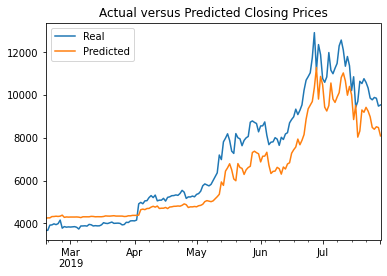

In [30]:
# Plot real vs. predicted prices on a line chart
equities.plot(title="Actual versus Predicted Closing Prices")

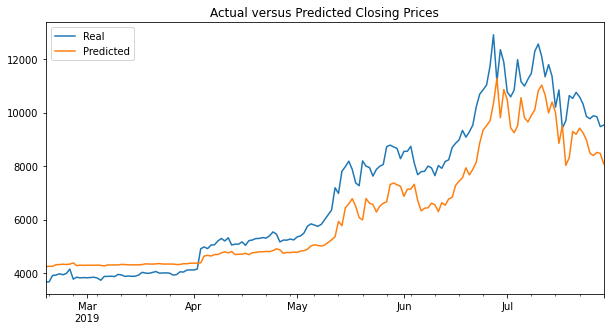

In [31]:
# Save cumulative returns as a .png file
equities.plot(figsize=(10,5), title="Actual versus Predicted Closing Prices").get_figure().savefig('actual_vs_predicted.png')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')